####                                                                    AAI-530-GROUP3-FINAL-PROJECT-SMARTAQ

### Objective: 

The goal of this project is to develop a medium-term prediction model for PM2.5 concentrations in Beijing using deep learning techniques, specifically Long Short-Term Memory (LSTM)

networks. Given the hourly recorded PM2.5 data and meteorological variables from 2010 to 2015, the project aims to predict PM2.5 levels for the next 7 days using historical trends,

seasonal variations, and meteorological influences.

By leveraging past PM2.5 readings and meteorological conditions (temperature, wind speed, atmospheric pressure, rainfall, snowfall, and dew point), the model will:

•	Quantify pollution trends over time.

•	Incorporate meteorological dependencies to refine PM2.5 predictions.

•	Identify seasonal variations in pollution patterns.

•	Assess policy effectiveness by analyzing historical and predicted trends.


The insights from this forecasting model will assist policymakers and environmental agencies in monitoring air pollution trends, implementing proactive pollution control measures, and 

assessing the impact of policy interventions like emission reductions and energy transitions.

### import all the libraries

In [53]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import zipfile
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

**Loading the dataset**

The features in th dataset are ,

No (Index/Serial Number): A unique identifier for each row in the dataset.

Year: The year in which the PM2.5 and meteorological data were recorded (2010–2015).

Month: The month (1–12) in which the data was recorded.Useful for capturing seasonal variations in PM2.5 levels.For example, higher levels in winter due to coal-based heating.

Day: The day of the month when the data was recorded (1–31).

Hour: The hour of the day when the data was recorded (0–23).

Dew Point: Dew point temperature.

Temperature: Atmospheric temperature in Celsius.

Pressure: Atmospheric pressure in hPa.

CBWD (Combined Wind Direction): A categorical variable representing wind direction (e.g., NW, NE, SW, SE).

IWS (Integrated Wind Speed):  The cumulative wind speed in meters per second (m/s) over a specific period.

IS (Integrated Snowfall): The cumulative snowfall in millimeters (mm) over a specific period.

IR (Integrated Rainfall): The cumulative rainfall in millimeters (mm) over a specific period.

PM2.5 (Target Variable): The concentration of fine particulate matter (PM2.5) in micrograms per cubic meter (µg/m³).




## data ingestion

In [54]:
import keras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

# Setting seed for reproducibility
np.random.seed(1234)  
PYTHONHASHSEED = 0

from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, recall_score, precision_score
from sklearn.model_selection import train_test_split
from keras.models import Sequential,load_model
from keras.layers import Dense, Dropout, LSTM, Activation
from keras.utils import pad_sequences

In [55]:
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00381/PRSA_data_2010.1.1-2014.12.31.csv'

df_raw = pd.read_csv(url)

df_raw.head()

,No,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
0,1,2010,1,1,0,NaN,-21,-11.0,1021.0,NW,1.79,0,0
1,2,2010,1,1,1,NaN,-21,-12.0,1020.0,NW,4.92,0,0
2,3,2010,1,1,2,NaN,-21,-11.0,1019.0,NW,6.71,0,0
3,4,2010,1,1,3,NaN,-21,-14.0,1019.0,NW,9.84,0,0
4,5,2010,1,1,4,NaN,-20,-12.0,1018.0,NW,12.97,0,0


In [56]:
# zip_path = "beijing+pm2+5+data.zip"

# # Opening the ZIP file
# with zipfile.ZipFile(zip_path, 'r') as z:
#     file_list = z.namelist()
#     print("Files in zip:", file_list)  

#     with z.open("PRSA_data_2010.1.1-2014.12.31.csv") as f:
#         df_raw = pd.read_csv(f, delimiter=",", low_memory=False)

# print(df_raw.head())

In [57]:
df_raw.describe()

,No,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,Iws,Is,Ir
count,43824.000000,43824.000000,43824.000000,43824.000000,43824.000000,41757.000000,43824.000000,43824.000000,43824.000000,43824.000000,43824.000000,43824.000000
mean,21912.500000,2012.000000,6.523549,15.727820,11.500000,98.613215,1.817246,12.448521,1016.447654,23.889140,0.052734,0.194916
std,12651.043435,1.413842,3.448572,8.799425,6.922266,92.050387,14.433440,12.198613,10.268698,50.010635,0.760375,1.415867
min,1.000000,2010.000000,1.000000,1.000000,0.000000,0.000000,-40.000000,-19.000000,991.000000,0.450000,0.000000,0.000000
25%,10956.750000,2011.000000,4.000000,8.000000,5.750000,29.000000,-10.000000,2.000000,1008.000000,1.790000,0.000000,0.000000
50%,21912.500000,2012.000000,7.000000,16.000000,11.500000,72.000000,2.000000,14.000000,1016.000000,5.370000,0.000000,0.000000
75%,32868.250000,2013.000000,10.000000,23.000000,17.250000,137.000000,15.000000,23.000000,1025.000000,21.910000,0.000000,0.000000
max,43824.000000,2014.000000,12.000000,31.000000,23.000000,994.000000,28.000000,42.000000,1046.000000,585.600000,27.000000,36.000000


The dataset doesn't have any null values except the column pm2.5

In [58]:
df_raw.dtypes

No         int64
year       int64
month      int64
day        int64
hour       int64
pm2.5    float64
DEWP       int64
TEMP     float64
PRES     float64
cbwd      object
Iws      float64
Is         int64
Ir         int64
dtype: object

In [59]:
#create a datetime feature from year,month,day and hour features
df_raw['datetime'] = pd.to_datetime(df_raw[['year', 'month', 'day', 'hour']])

# Format the Datetime column as yyyy-mm-dd HH:mm:ss
df_raw['datetime'] = df_raw['datetime'].dt.strftime('%Y-%m-%d %H:%M:%S')

# first few rows to verify
df_raw.head()

,No,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir,datetime
0,1,2010,1,1,0,NaN,-21,-11.0,1021.0,NW,1.79,0,0,2010-01-01 00:00:00
1,2,2010,1,1,1,NaN,-21,-12.0,1020.0,NW,4.92,0,0,2010-01-01 01:00:00
2,3,2010,1,1,2,NaN,-21,-11.0,1019.0,NW,6.71,0,0,2010-01-01 02:00:00
3,4,2010,1,1,3,NaN,-21,-14.0,1019.0,NW,9.84,0,0,2010-01-01 03:00:00
4,5,2010,1,1,4,NaN,-20,-12.0,1018.0,NW,12.97,0,0,2010-01-01 04:00:00


In [60]:
df_raw.tail()

,No,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir,datetime
43819,43820,2014,12,31,19,8.0,-23,-2.0,1034.0,NW,231.97,0,0,2014-12-31 19:00:00
43820,43821,2014,12,31,20,10.0,-22,-3.0,1034.0,NW,237.78,0,0,2014-12-31 20:00:00
43821,43822,2014,12,31,21,10.0,-22,-3.0,1034.0,NW,242.70,0,0,2014-12-31 21:00:00
43822,43823,2014,12,31,22,8.0,-22,-4.0,1034.0,NW,246.72,0,0,2014-12-31 22:00:00
43823,43824,2014,12,31,23,12.0,-21,-3.0,1034.0,NW,249.85,0,0,2014-12-31 23:00:00


In [61]:
df = df_raw.copy()

In [62]:

# Create Datetime Column
df['datetime'] = pd.to_datetime(df[['year', 'month', 'day', 'hour']])

# Convert to Unix Timestamp (Seconds since 1970-01-01)
df['unix_time'] = df['datetime'].astype('int64') // 10**9  # Convert to seconds

In [63]:
df[['datetime', 'unix_time']].head()

,datetime,unix_time
0,2010-01-01 00:00:00,1262304000
1,2010-01-01 01:00:00,1262307600
2,2010-01-01 02:00:00,1262311200
3,2010-01-01 03:00:00,1262314800
4,2010-01-01 04:00:00,1262318400


## data cleaning

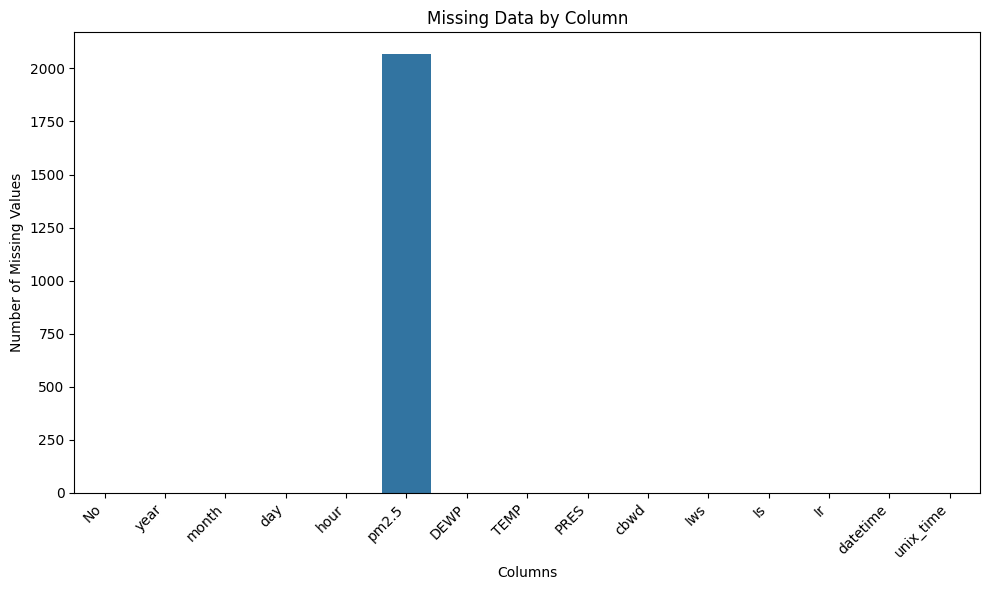

In [64]:
# Check for missing values
missing_counts = df.isnull().sum()

# Visualize missing values
plt.figure(figsize=(10, 6))
sns.barplot(x=missing_counts.index, y=missing_counts.values)
plt.xticks(rotation=45, ha='right')
plt.title('Missing Data by Column')
plt.ylabel('Number of Missing Values')
plt.xlabel('Columns')
plt.tight_layout()
plt.show()

<Axes: title={'center': 'NaN Counts Over Time'}, xlabel='datetime'>

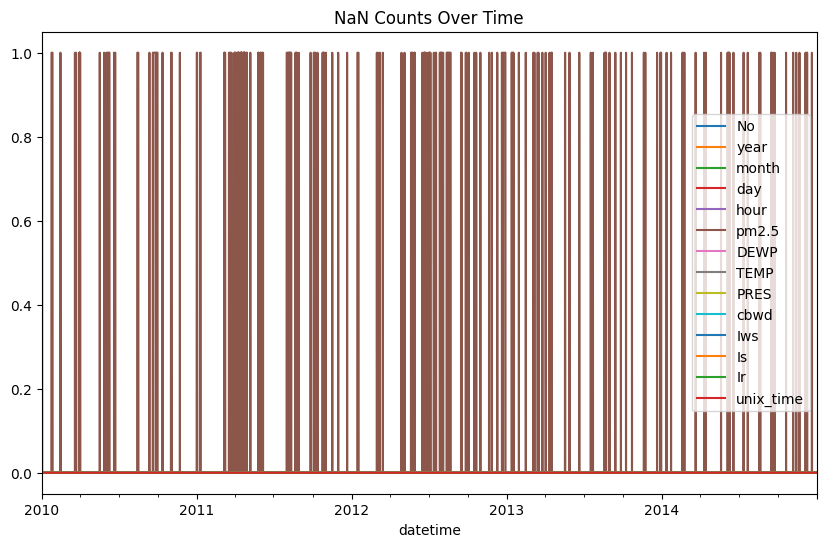

In [65]:
# Drop unwanted columns for NaN analysis (excluding 'Datetime' or 'Date')
df_na = df.drop('datetime', axis=1).isna().groupby(df['datetime'], sort=False).sum().reset_index()

# Plot NaN counts over time using 'Datetime' as x-axis
df_na.plot(x='datetime', y=df_na.columns[1:], figsize=(10, 6), title="NaN Counts Over Time")

These missing values are distributed throughout the dataset and are not uniformly distributed.Certain periods show clusters of missing values (entire sections are missing) and Other periods have sporadic gaps. Missing data in pm2.5 might be due to sensor failure, data collection issues, or external factors like weather or maintenance. This pattern suggests the need to investigate if missing data aligns with specific months, seasons, or hours of the day. Gaps in pm2.5 data could affect trend and seasonal analysis. Imputation or interpolation will likely be needed. The high number of missing values might make it challenging to perform accurate predictions without a robust handling strategy. 

In [66]:
missing_percent = df.isnull().mean() * 100
print(missing_percent)

No           0.000000
year         0.000000
month        0.000000
day          0.000000
hour         0.000000
pm2.5        4.716594
DEWP         0.000000
TEMP         0.000000
PRES         0.000000
cbwd         0.000000
Iws          0.000000
Is           0.000000
Ir           0.000000
datetime     0.000000
unix_time    0.000000
dtype: float64


A missing rate of 4.71% is relatively low and manageable in most cases. Handling missing data will affect a small portion of your dataset, so most of the data remains intact for analysis.

In [67]:
#linear interpolation for numeric columns to fill missing values
df_numeric = df.drop(columns=['datetime'])  # Exclude non-numeric columns
df_numeric = df_numeric.interpolate(method='linear', limit_direction='both')

# Replace original numeric columns with imputed values
df.update(df_numeric)

# Verify missing data is handled
print(df.isna().sum())

No           0
year         0
month        0
day          0
hour         0
pm2.5        0
DEWP         0
TEMP         0
PRES         0
cbwd         0
Iws          0
Is           0
Ir           0
datetime     0
unix_time    0
dtype: int64


/var/folders/80/hnfw_r755zsgd6zb_n_95hyh0000gn/T/ipykernel_64676/2951410894.py:3: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  df_numeric = df_numeric.interpolate(method='linear', limit_direction='both')


In [68]:
desc = df.describe()

print(desc)

                 No          year         month           day          hour  \
count  43824.000000  43824.000000  43824.000000  43824.000000  43824.000000   
mean   21912.500000   2012.000000      6.523549     15.727820     11.500000   
min        1.000000   2010.000000      1.000000      1.000000      0.000000   
25%    10956.750000   2011.000000      4.000000      8.000000      5.750000   
50%    21912.500000   2012.000000      7.000000     16.000000     11.500000   
75%    32868.250000   2013.000000     10.000000     23.000000     17.250000   
max    43824.000000   2014.000000     12.000000     31.000000     23.000000   
std    12651.043435      1.413842      3.448572      8.799425      6.922266   

              pm2.5          DEWP          TEMP          PRES           Iws  \
count  43824.000000  43824.000000  43824.000000  43824.000000  43824.000000   
mean      98.261809      1.817246     12.448521   1016.447654     23.889140   
min        0.000000    -40.000000    -19.000000    

In [69]:
# Count rows NOT between 2010 and 2014
count_outside_range = df[(df_raw['year'] < 2010) | (df['year'] > 2014)].shape[0]

# Display the count
count_outside_range

0

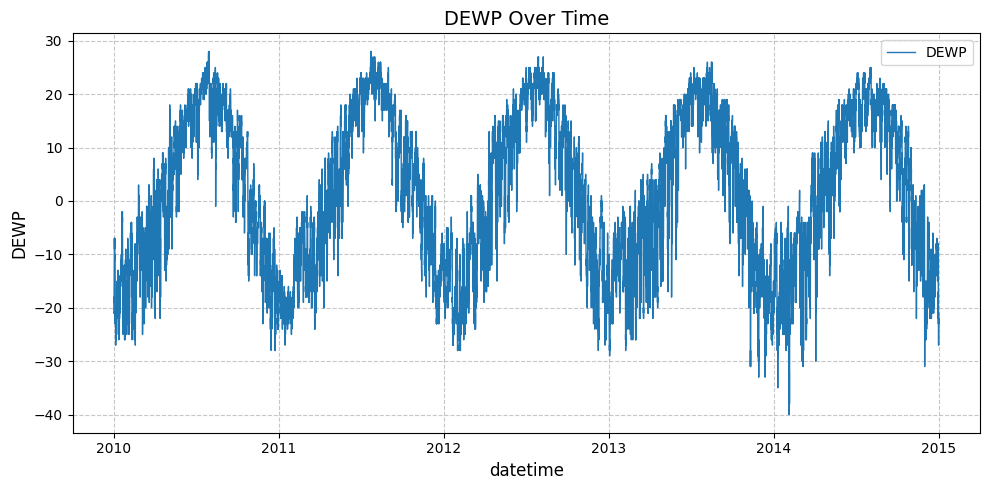

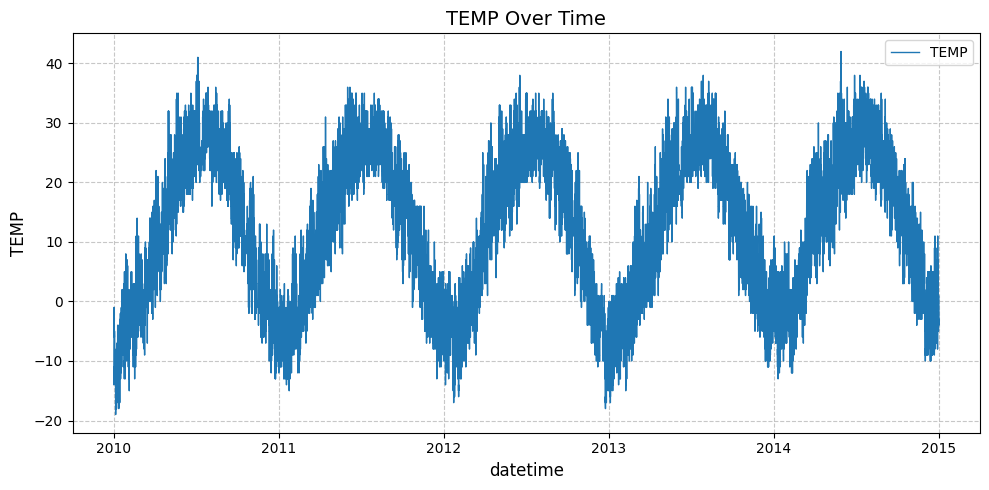

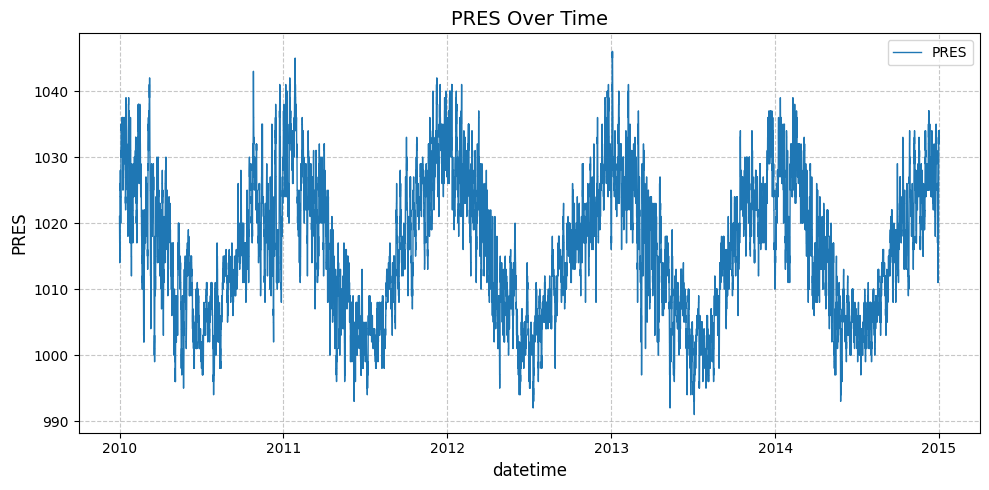

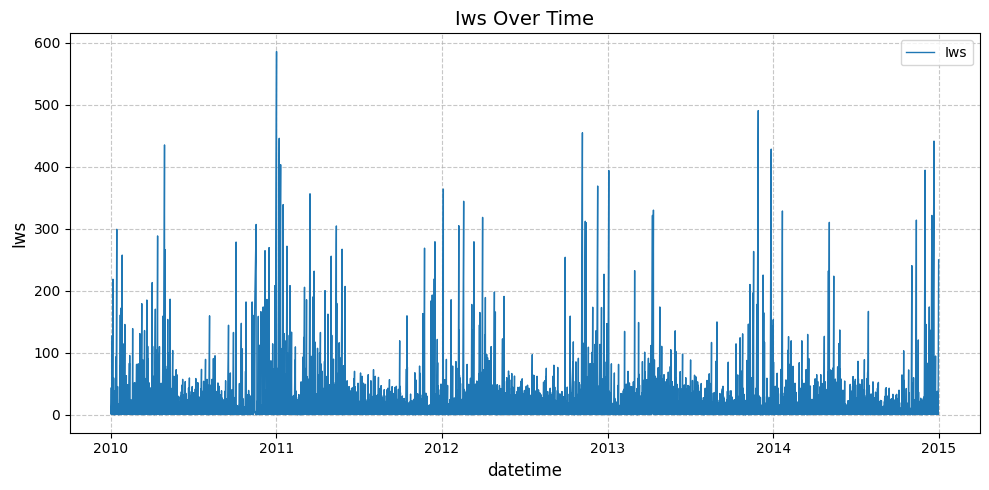

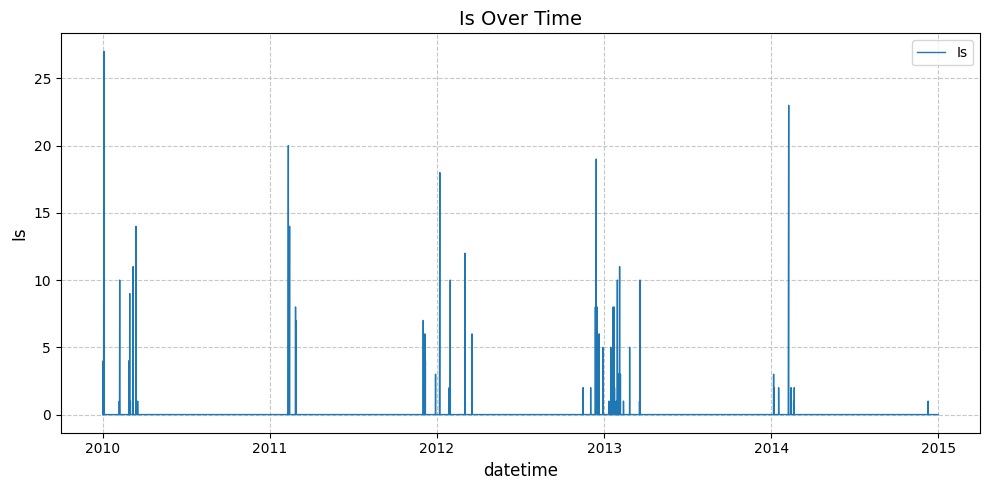

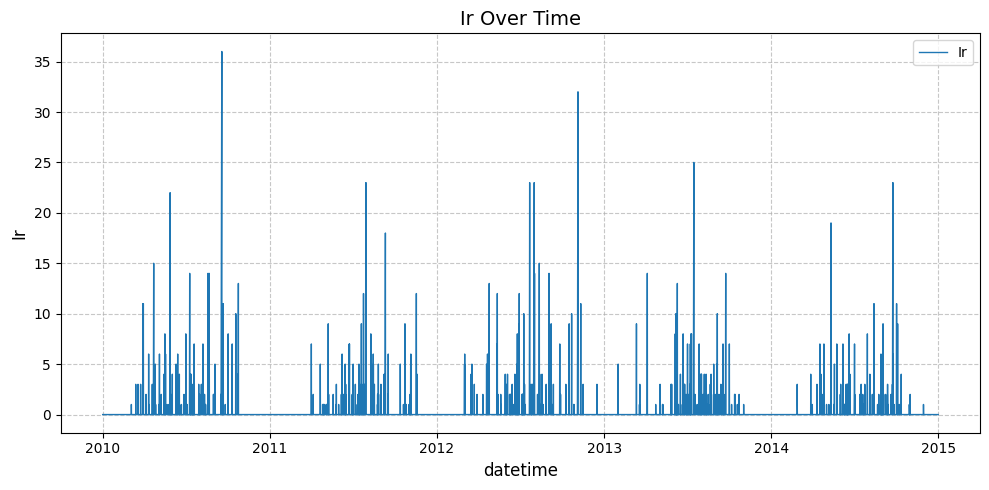

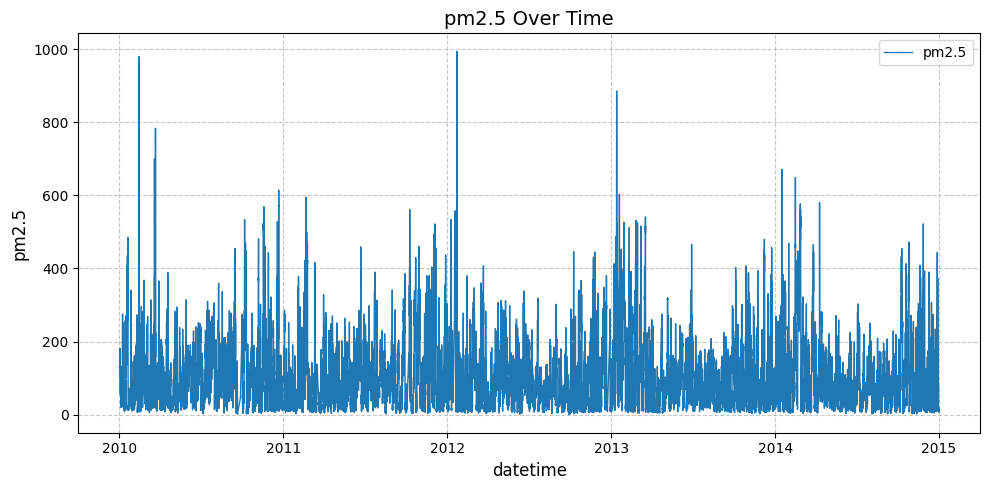

In [70]:
#build your line chart here
variables_to_plot = ['DEWP', 'TEMP', 'PRES', 'Iws', 'Is', 'Ir', 'pm2.5']

# Plot each variable
for variable in variables_to_plot:
    plt.figure(figsize=(10, 5))
    plt.plot(df['datetime'], df[variable], label=variable, linewidth=1)
    plt.title(f"{variable} Over Time", fontsize=14)
    plt.xlabel("datetime", fontsize=12)
    plt.ylabel(variable, fontsize=12)
    plt.legend(loc='upper right', fontsize=10)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

## Feature Engineering

/var/folders/80/hnfw_r755zsgd6zb_n_95hyh0000gn/T/ipykernel_64676/1185217247.py:9: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  pd.Grouper(freq='M')  # 'M' represents monthly frequency


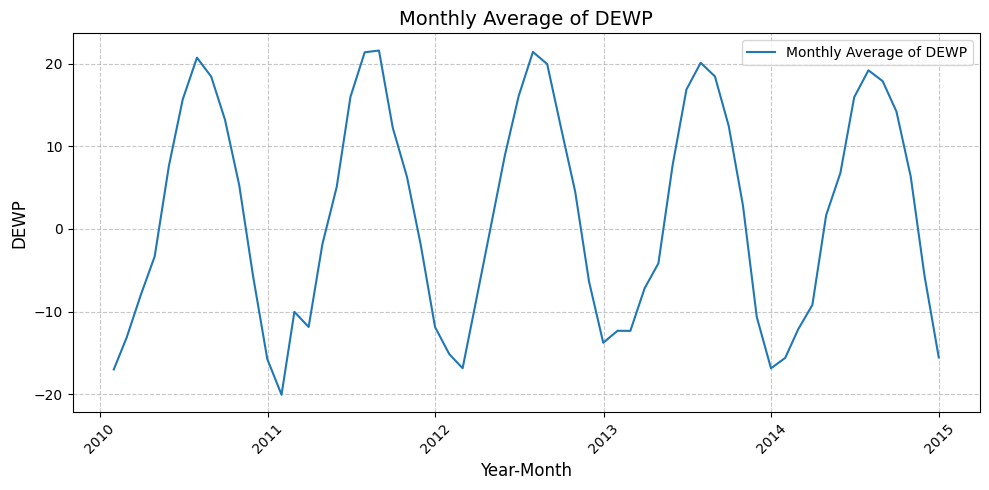

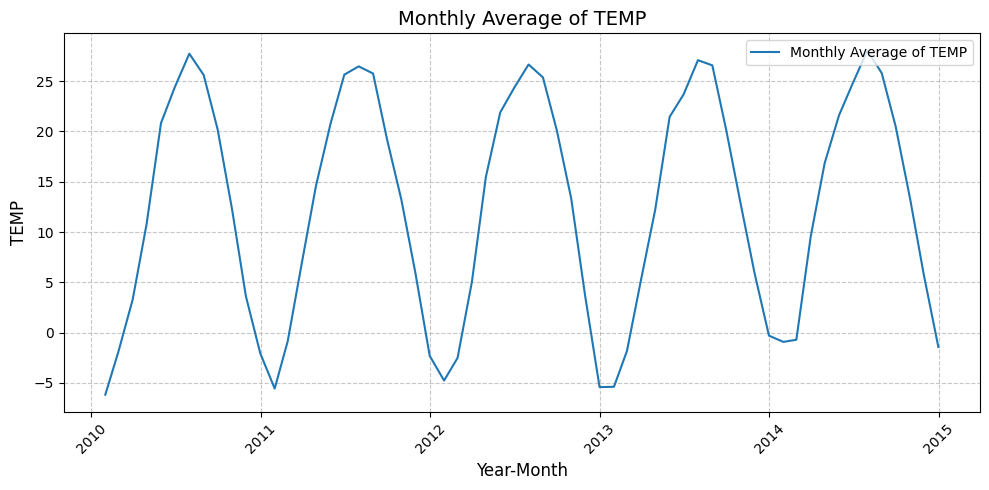

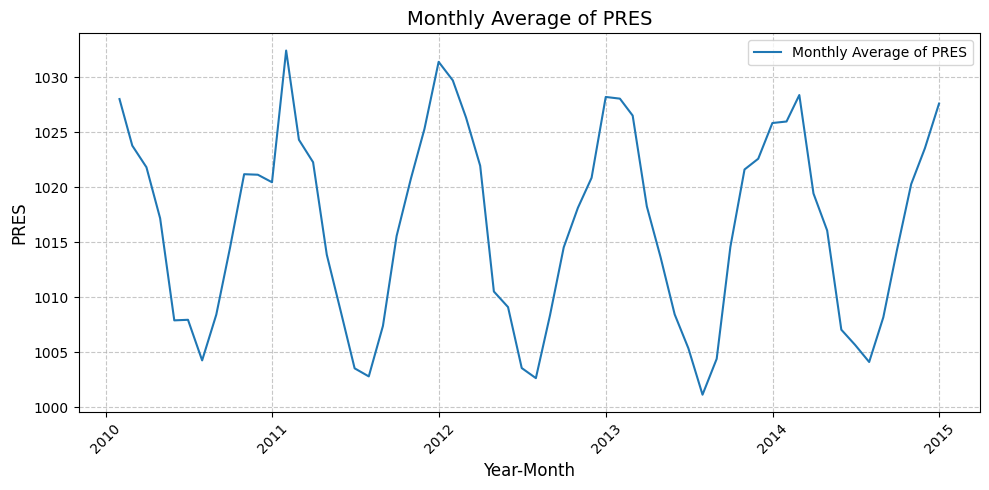

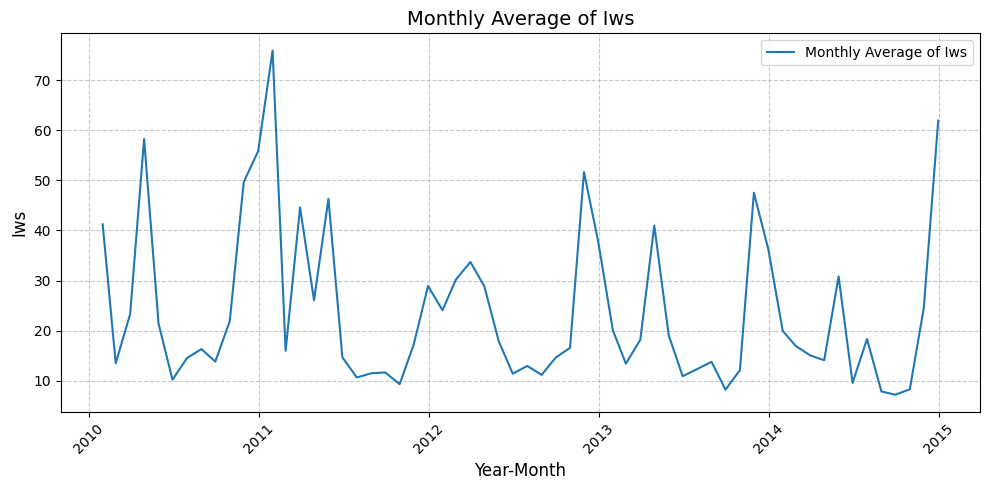

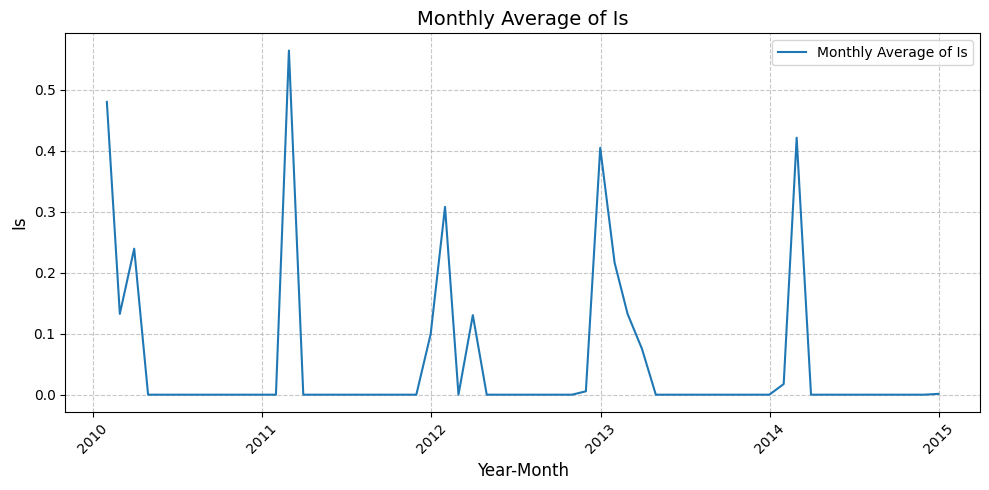

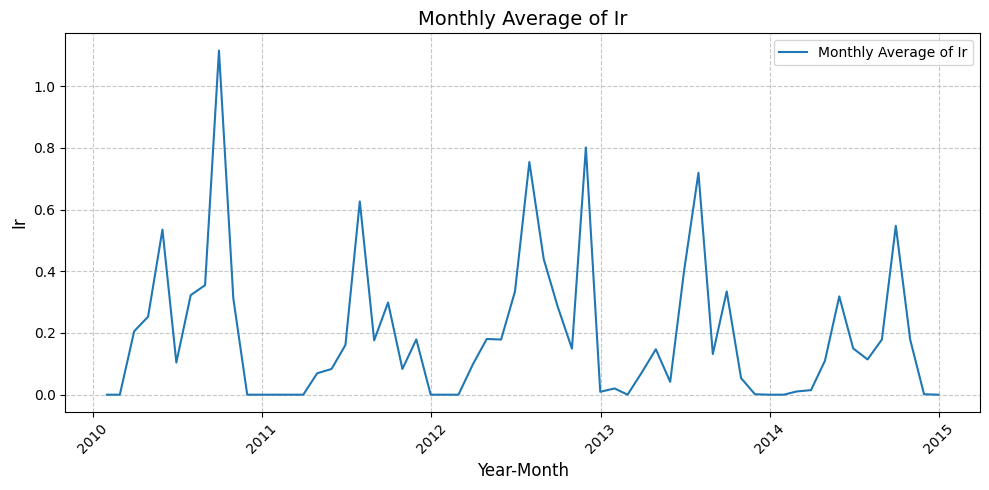

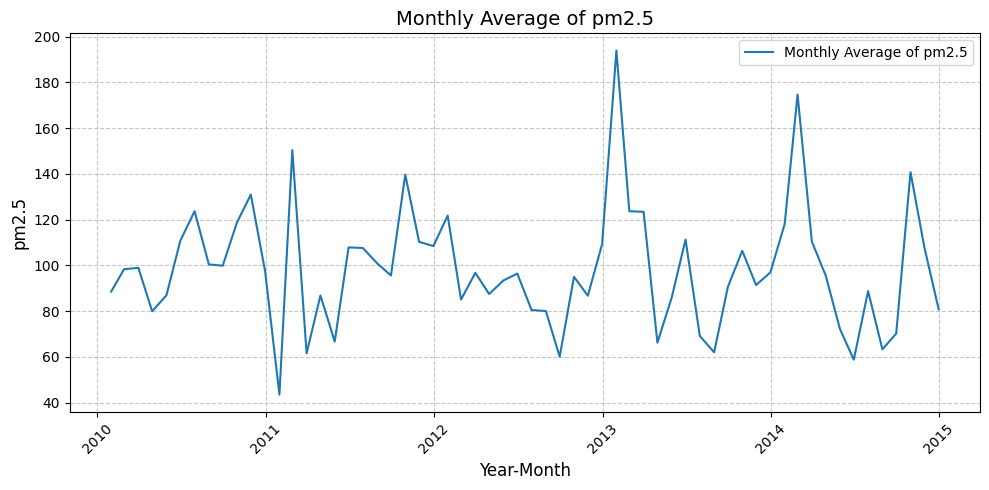

In [71]:
# Combine year, month, day, and hour to create 'Datetime'
df['datetime'] = pd.to_datetime(df_raw[['year', 'month', 'day', 'hour']])

# 'Datetime' as the index
df.set_index('datetime', inplace=True)

# Group by monthly intervals and calculate the mean
monthly_avg = df.groupby(
    pd.Grouper(freq='M')  # 'M' represents monthly frequency
)[['DEWP', 'TEMP', 'PRES', 'Iws', 'Is', 'Ir','pm2.5']].mean().reset_index()

# Function to plot the monthly average
def plot_monthly_average(data, variables, datetime_column):
    for variable in variables:
        plt.figure(figsize=(10, 5))
        plt.plot(data[datetime_column], data[variable], label=f"Monthly Average of {variable}", linewidth=1.5)
        plt.title(f"Monthly Average of {variable}", fontsize=14)
        plt.xlabel("Year-Month", fontsize=12)
        plt.ylabel(variable, fontsize=12)
        plt.xticks(rotation=45, fontsize=10)
        plt.legend(loc='upper right', fontsize=10)
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.tight_layout()
        plt.show()

# the plotting function
plot_monthly_average(
    data=monthly_avg,
    variables=['DEWP', 'TEMP', 'PRES', 'Iws', 'Is', 'Ir', 'pm2.5'],
    datetime_column='datetime'
)

Uses a rolling window of 30 days (720 hours)

Computes the moving average for each selected feature

Uses min_periods=1 to prevent NaN values at the beginning

Stores results in a new DataFrame (df_moving_avg)

Processed 30-Day Moving Average Data:
             datetime  No  year  month  day  hour  pm2.5  DEWP       TEMP  \
0 2010-01-01 00:00:00   1  2010      1    1     0  129.0 -21.0 -11.000000   
1 2010-01-01 01:00:00   2  2010      1    1     1  129.0 -21.0 -11.500000   
2 2010-01-01 02:00:00   3  2010      1    1     2  129.0 -21.0 -11.333333   
3 2010-01-01 03:00:00   4  2010      1    1     3  129.0 -21.0 -12.000000   
4 2010-01-01 04:00:00   5  2010      1    1     4  129.0 -20.8 -12.000000   

      PRES cbwd       Iws   Is   Ir   unix_time  
0  1021.00   NW  1.790000  0.0  0.0  1262304000  
1  1020.50   NW  3.355000  0.0  0.0  1262307600  
2  1020.00   NW  4.473333  0.0  0.0  1262311200  
3  1019.75   NW  5.815000  0.0  0.0  1262314800  
4  1019.40   NW  7.246000  0.0  0.0  1262318400  


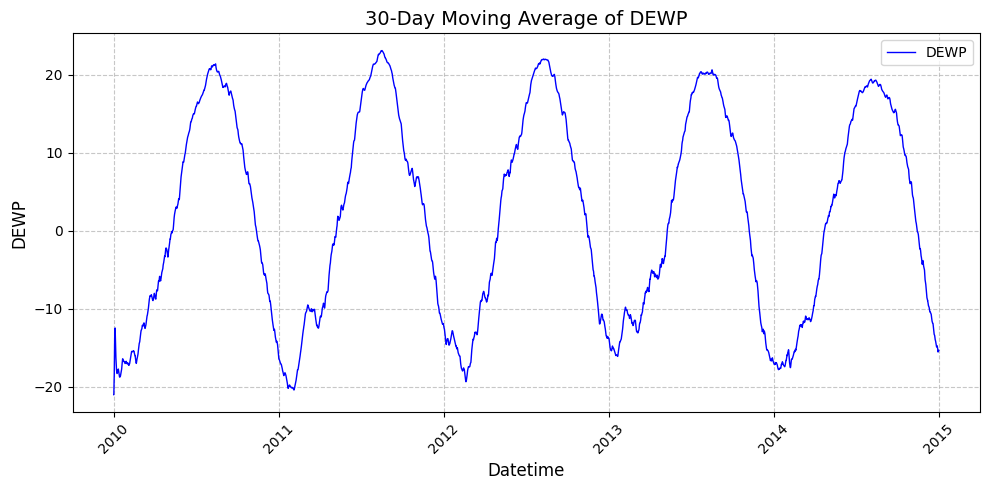

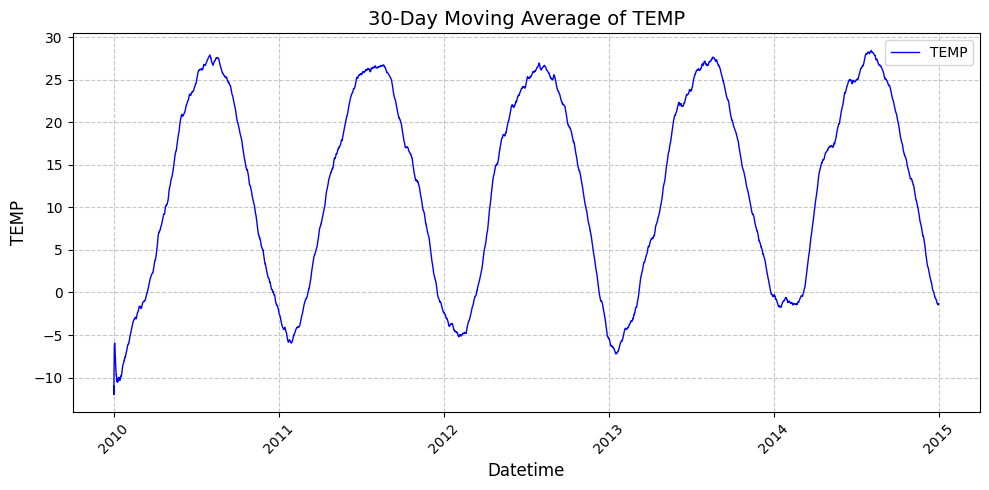

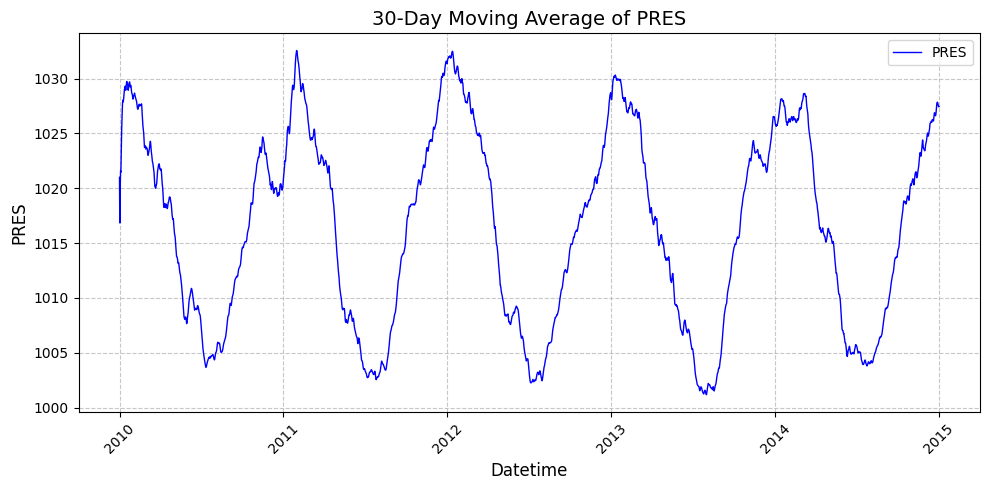

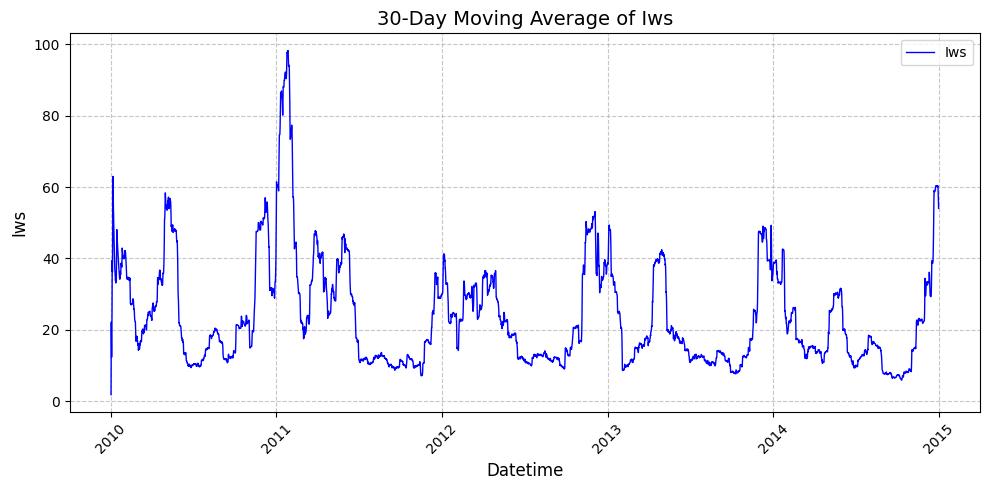

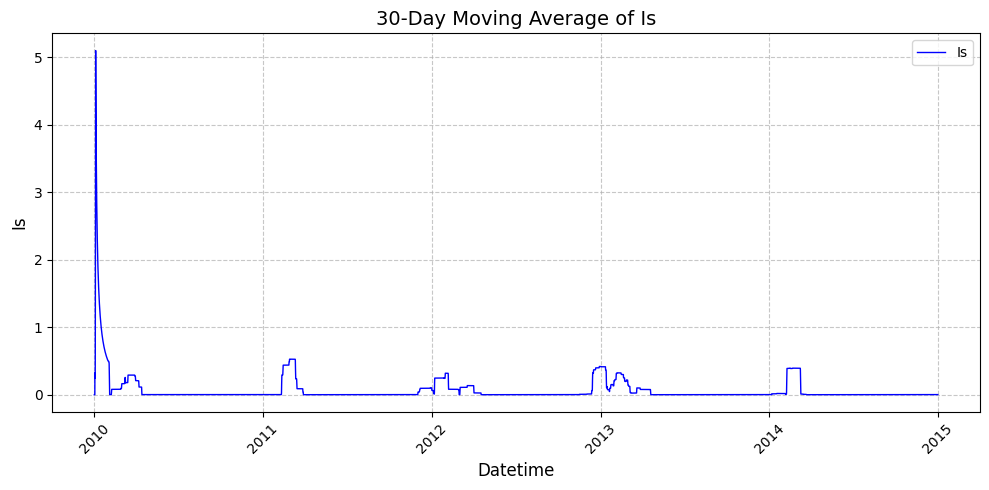

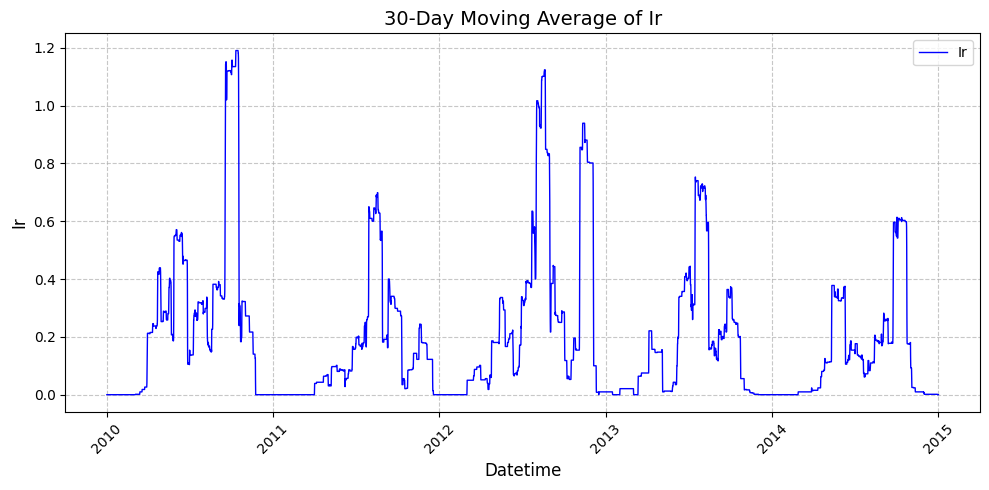

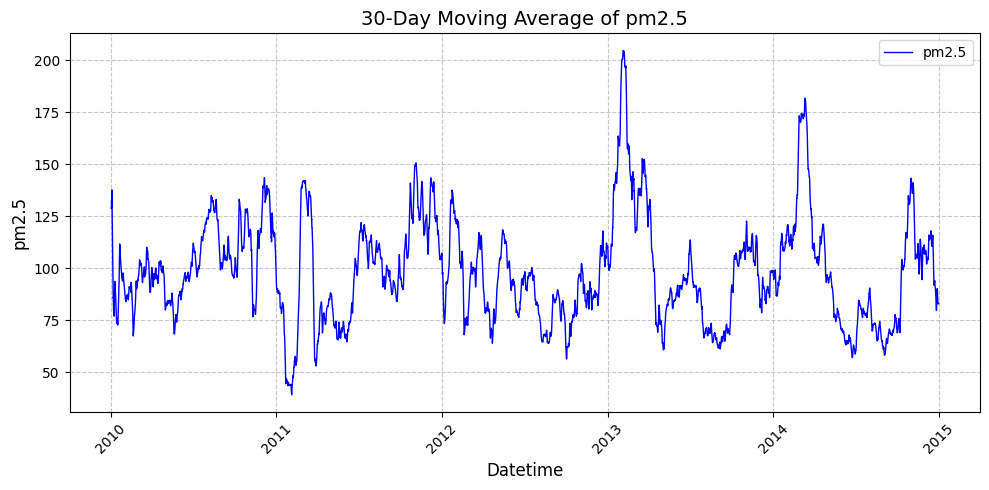

In [72]:
df_moving_avg = df.copy()

# Check if 'datetime' is an index, reset it if necessary
if df_moving_avg.index.name == 'datetime':
    df_moving_avg.reset_index(inplace=True)

if 'datetime' not in df_moving_avg.columns:
    raise KeyError("The 'datetime' column is missing from the dataset. Check column names.")

# Converting datetime column to datetime format
df_moving_avg['datetime'] = pd.to_datetime(df_moving_avg['datetime'])

# 'datetime' as index for time-based rolling window
df_moving_avg.set_index('datetime', inplace=True)

# Define the rolling window size (30 days = 720 hours)
window_size = 30 * 24  # Time-based rolling window of 30 days

# List of features to apply the moving average
features_to_smooth = ['DEWP', 'TEMP', 'PRES', 'Iws', 'Is', 'Ir', 'pm2.5']

# Apply 30-day moving average using time-based rolling
df_moving_avg[features_to_smooth] = df_moving_avg[features_to_smooth].rolling(window=window_size, min_periods=1).mean()

# Reset index to keep datetime as a column again
df_moving_avg.reset_index(inplace=True)

# Display first few rows
print("Processed 30-Day Moving Average Data:")
print(df_moving_avg.head())

# Save the processed dataframe to a CSV file (optional)
df_moving_avg.to_csv("30_day_moving_avg_data.csv", index=False)

# Plot the moving averages
for variable in ['DEWP', 'TEMP', 'PRES', 'Iws', 'Is', 'Ir', 'pm2.5']:
    plt.figure(figsize=(10, 5))
    plt.plot(df_moving_avg['datetime'], df_moving_avg[variable], label=variable, linewidth=1, color='blue')
    plt.title(f"30-Day Moving Average of {variable}", fontsize=14)
    plt.xlabel("Datetime", fontsize=12)
    plt.ylabel(variable, fontsize=12)
    plt.xticks(rotation=45, fontsize=10)
    plt.legend(loc='upper right', fontsize=10)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()



Lets take a look at correlation matrix for the main features of original dataframe

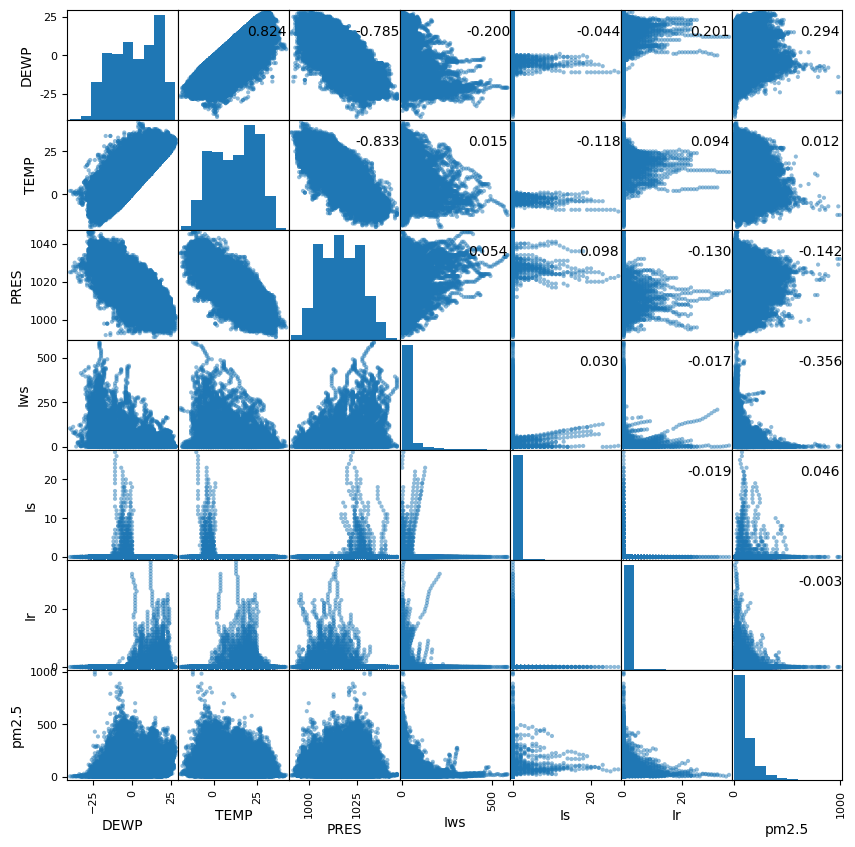

In [73]:
axes = pd.plotting.scatter_matrix(df[['DEWP', 'TEMP', 'PRES', 'Iws', 'Is', 'Ir','pm2.5']], alpha=0.5,figsize = [10,10])
corr = df[['DEWP', 'TEMP', 'PRES', 'Iws', 'Is', 'Ir','pm2.5']].corr(method = 'spearman').to_numpy() #nonlinear
for i, j in zip(*plt.np.triu_indices_from(axes, k=1)):
    axes[i, j].annotate("%.3f" %corr[i,j], (0.8, 0.8), xycoords='axes fraction', ha='center', va='center')
plt.show()

In [74]:
# wind_mapping = {'NW': 1, 'NE': 2, 'SW': 3, 'SE': 4}
# df['cbwd_encoded'] = df['cbwd'].map(wind_mapping)

# wind_angles = {'NW': 315, 'NE': 45, 'SW': 225, 'SE': 135}  # Approximate wind angles
# df['cbwd_angle'] = df['cbwd'].map(wind_angles)
# df['cbwd_sin'] = np.sin(np.radians(df['cbwd_angle']))
# df['cbwd_cos'] = np.cos(np.radians(df['cbwd_angle']))



In [75]:
wind_mapping = {'NW': 1, 'NE': 2, 'SW': 3, 'SE': 4}
df_moving_avg['cbwd_encoded'] = df_moving_avg['cbwd'].map(wind_mapping)

wind_angles = {'NW': 315, 'NE': 45, 'SW': 225, 'SE': 135}  # Approximate wind angles
df_moving_avg['cbwd_angle'] = df_moving_avg['cbwd'].map(wind_angles)
df_moving_avg['cbwd_sin'] = np.sin(np.radians(df_moving_avg['cbwd_angle']))
df_moving_avg['cbwd_cos'] = np.cos(np.radians(df_moving_avg['cbwd_angle']))

In [76]:
df_moving_avg.tail()

,datetime,No,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir,unix_time,cbwd_encoded,cbwd_angle,cbwd_sin,cbwd_cos
43819,2014-12-31 19:00:00,43820,2014,12,31,19,83.005556,-15.327778,-1.362500,1027.450000,NW,54.809625,0.001389,0.0,1420052400,1.0,315.0,-0.707107,0.707107
43820,2014-12-31 20:00:00,43821,2014,12,31,20,82.993056,-15.327778,-1.358333,1027.451389,NW,54.617083,0.001389,0.0,1420056000,1.0,315.0,-0.707107,0.707107
43821,2014-12-31 21:00:00,43822,2014,12,31,21,82.995833,-15.329167,-1.355556,1027.452778,NW,54.425792,0.001389,0.0,1420059600,1.0,315.0,-0.707107,0.707107
43822,2014-12-31 22:00:00,43823,2014,12,31,22,82.986111,-15.329167,-1.354167,1027.452778,NW,54.233250,0.001389,0.0,1420063200,1.0,315.0,-0.707107,0.707107
43823,2014-12-31 23:00:00,43824,2014,12,31,23,82.991667,-15.330556,-1.348611,1027.454167,NW,54.040708,0.001389,0.0,1420066800,1.0,315.0,-0.707107,0.707107


In [77]:
# if isinstance(df.index, pd.DatetimeIndex):
#     print("'datetime' is the index in df.")
# else:
#     print("'datetime' is NOT the index in df.")

# # Check if 'datetime' is the index in df_moving_avg
# if isinstance(df_moving_avg.index, pd.DatetimeIndex):
#     print("'datetime' is the index in df_moving_avg.")
# else:
#     print("'datetime' is NOT the index in df_moving_avg.")

# # Set datetime as index
# if 'datetime' in df.columns:
#     df['datetime'] = pd.to_datetime(df['datetime'], errors='coerce')
#     df.set_index('datetime', inplace=True)
#     print("'datetime' is now set as the index for df.")
# else:
#     print("'datetime' column is missing in df. Check dataset columns:", df.columns)


# if 'datetime' in df_moving_avg.columns:
#     df_moving_avg['datetime'] = pd.to_datetime(df_moving_avg['datetime'], errors='coerce')
#     df_moving_avg.set_index('datetime', inplace=True)
#     print("'datetime' is now set as the index for df_moving_avg.")
# else:
#     print("'datetime' column is missing in df_moving_avg. Check dataset columns:", df_moving_avg.columns)

# print(df.index)
# print(df_moving_avg.index)



In [78]:
# # Remove the 'Datetime' column from df_moving_avg (if it exists)
# if 'datetime' in df_moving_avg.columns:
#     df_moving_avg = df_moving_avg.drop(columns='datetime')

# # Verify the result
# print(df_moving_avg.head())

In [79]:
# # Remove columns in df that have the same names as in df_moving_avg (excluding the index)
# columns_to_drop = [col for col in df.columns if col in df_moving_avg.columns]
# df_filtered = df.drop(columns=columns_to_drop, errors='ignore')

# # Merge the two DataFrames on the 'Datetime' index
# merged_df = pd.merge(
#     df_filtered,
#     df_moving_avg,
#     left_index=True,   # Merge on the 'Datetime' index of df_raw
#     right_index=True,  # Merge on the 'Datetime' index of df_moving_avg
#     how='inner'        # Use inner join to keep only matching rows
# )

# # Display the result
# merged_df.head()

Correlation Matrix:
                  DEWP      TEMP      PRES       Iws        Is        Ir  \
DEWP          1.000000  0.966303 -0.901822 -0.619877 -0.344264  0.602646   
TEMP          0.966303  1.000000 -0.946358 -0.552976 -0.421175  0.535339   
PRES         -0.901822 -0.946358  1.000000  0.453904  0.334760 -0.497139   
Iws          -0.619877 -0.552976  0.453904  1.000000  0.132667 -0.276594   
Is           -0.344264 -0.421175  0.334760  0.132667  1.000000 -0.210726   
Ir            0.602646  0.535339 -0.497139 -0.276594 -0.210726  1.000000   
pm2.5        -0.245693 -0.342932  0.359952 -0.233124  0.156632 -0.188608   
unix_time     0.090071  0.127977 -0.060717 -0.254802 -0.191029 -0.071828   
cbwd_encoded  0.247172  0.281823 -0.298392 -0.211141 -0.110422  0.108186   
cbwd_angle   -0.193240 -0.212564  0.220135  0.185729  0.072425 -0.088030   
cbwd_sin      0.229914  0.256942 -0.268749 -0.210238 -0.093398  0.102944   
cbwd_cos     -0.234333 -0.269761  0.287254  0.193322  0.109298 -0.10

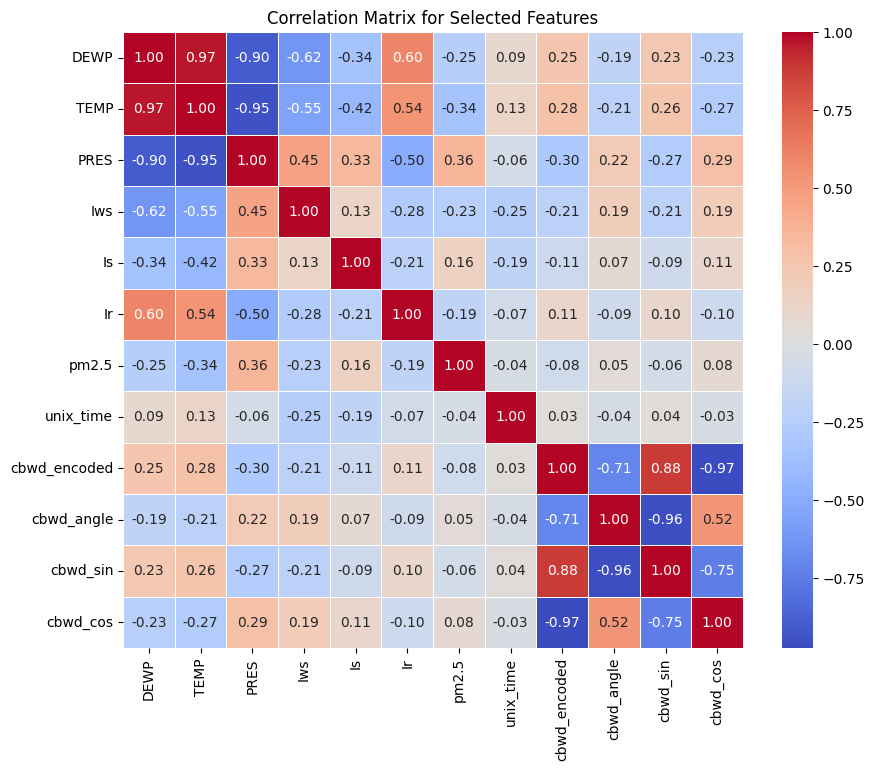

In [80]:
# Select the features of interest
selected_features = ['DEWP', 'TEMP', 'PRES', 'Iws', 'Is', 'Ir', 'pm2.5', 'unix_time', 'cbwd_encoded', 'cbwd_angle',	'cbwd_sin',	'cbwd_cos']
df_selected = df_moving_avg[selected_features]

# Compute the correlation matrix
correlation_matrix = df_selected.corr()

# Display the correlation matrix
print("Correlation Matrix:")
print(correlation_matrix)

# Visualize the correlation matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix for Selected Features")
plt.show()

In [81]:
df_moving_avg = df_moving_avg.drop(columns=['DEWP', 'cbwd', 'No', 'unix_time'], errors='ignore')

df_moving_avg.head()

,datetime,year,month,day,hour,pm2.5,TEMP,PRES,Iws,Is,Ir,cbwd_encoded,cbwd_angle,cbwd_sin,cbwd_cos
0,2010-01-01 00:00:00,2010,1,1,0,129.0,-11.000000,1021.00,1.790000,0.0,0.0,1.0,315.0,-0.707107,0.707107
1,2010-01-01 01:00:00,2010,1,1,1,129.0,-11.500000,1020.50,3.355000,0.0,0.0,1.0,315.0,-0.707107,0.707107
2,2010-01-01 02:00:00,2010,1,1,2,129.0,-11.333333,1020.00,4.473333,0.0,0.0,1.0,315.0,-0.707107,0.707107
3,2010-01-01 03:00:00,2010,1,1,3,129.0,-12.000000,1019.75,5.815000,0.0,0.0,1.0,315.0,-0.707107,0.707107
4,2010-01-01 04:00:00,2010,1,1,4,129.0,-12.000000,1019.40,7.246000,0.0,0.0,1.0,315.0,-0.707107,0.707107


In [82]:
df_moving_avg.dtypes

datetime        datetime64[ns]
year                     int64
month                    int64
day                      int64
hour                     int64
pm2.5                  float64
TEMP                   float64
PRES                   float64
Iws                    float64
Is                     float64
Ir                     float64
cbwd_encoded           float64
cbwd_angle             float64
cbwd_sin               float64
cbwd_cos               float64
dtype: object

In [83]:
# # if 'Datetime' is set as the index, then reset it
# if isinstance(merged_df.index, pd.DatetimeIndex):
#     merged_df = merged_df.reset_index(drop=True)

# # Reset index (only if the DataFrame has a named index)
# if merged_df.index.name is not None:
#     merged_df = merged_df.reset_index()


## Feature engineered dataset

In [84]:
# columns_to_drop = ['year', 'month', 'day', 'hour',]
# merged_df = merged_df.drop(columns=[col for col in columns_to_drop if col in df.columns], errors='ignore')

# # Sort by datetime to maintain time sequence
# merged_df = merged_df.sort_values(by='datetime')

In [85]:
# # the file path where you want to save the CSV
# file_path = "merged_data.csv"

# # Save the DataFrame to a CSV file
# merged_df.to_csv(file_path, index=True)  # Include the index (Datetime) in the CSV

# # Confirm the file was saved
# print(f"DataFrame saved to {file_path}")



## Normalize the dataset

In [86]:
from sklearn.preprocessing import MinMaxScaler

# Exclude 'datetime' from normalization if it exists
exclude_features = ['datetime']
features_to_normalize = [col for col in df_moving_avg.columns if col not in exclude_features]

# Initialize MinMaxScaler
scaler = MinMaxScaler()

# Apply MinMaxScaler to selected features
df_scaled_values = scaler.fit_transform(df_moving_avg[features_to_normalize])

# Convert back to DataFrame with original column names
df_scaled = pd.DataFrame(df_scaled_values, columns=features_to_normalize)

# # Add back the excluded datetime feature if it exists
# if 'datetime' in df_moving_avg.columns:
#     df_scaled['datetime'] = df_moving_avg['datetime']

# # Reorder columns to maintain original structure
# if 'datetime' in df_scaled.columns:
#     df_scaled = df_scaled[['datetime'] + features_to_normalize]

# Display first few rows
print("MinMax Scaled Dataset (Excluding datetime):")
print(df_scaled.head())

# Optional: Save the final dataset
df_scaled.to_csv("minmax_scaled_dataset.csv", index=False)

MinMax Scaled Dataset (Excluding datetime):
   year  month  day      hour     pm2.5      TEMP      PRES       Iws   Is  \
0   0.0    0.0  0.0  0.000000  0.542532  0.024746  0.631528  0.000000  0.0   
1   0.0    0.0  0.0  0.043478  0.542532  0.012373  0.615596  0.016216  0.0   
2   0.0    0.0  0.0  0.086957  0.542532  0.016497  0.599664  0.027805  0.0   
3   0.0    0.0  0.0  0.130435  0.542532  0.000000  0.591698  0.041707  0.0   
4   0.0    0.0  0.0  0.173913  0.542532  0.000000  0.580545  0.056535  0.0   

    Ir  cbwd_encoded  cbwd_angle  cbwd_sin  cbwd_cos  
0  0.0           0.0         1.0       0.0       1.0  
1  0.0           0.0         1.0       0.0       1.0  
2  0.0           0.0         1.0       0.0       1.0  
3  0.0           0.0         1.0       0.0       1.0  
4  0.0           0.0         1.0       0.0       1.0  


In [87]:
# Display only the 'datetime' column if it exists
if 'datetime' in df_scaled.columns:
    print(df_scaled[['datetime']].head())
else:
    print("⚠️ Warning: 'datetime' column is not present in df_scaled.")

⚠️ Warning: 'datetime' column is not present in df_scaled.


In [88]:
# scaled_df = merged_df.drop(columns='cbwd', errors='ignore')


In [89]:
# the file path where you want to save the CSV
file_path = "feature_eng_data.csv"

# Save the DataFrame to a CSV file
df_scaled.to_csv(file_path, index=True)  # Include the index (Datetime) in the CSV

# Confirm the file was saved
print(f"DataFrame saved to {file_path}")

DataFrame saved to feature_eng_data.csv


In [90]:
df_scaled.head()

,year,month,day,hour,pm2.5,TEMP,PRES,Iws,Is,Ir,cbwd_encoded,cbwd_angle,cbwd_sin,cbwd_cos
0,0.0,0.0,0.0,0.000000,0.542532,0.024746,0.631528,0.000000,0.0,0.0,0.0,1.0,0.0,1.0
1,0.0,0.0,0.0,0.043478,0.542532,0.012373,0.615596,0.016216,0.0,0.0,0.0,1.0,0.0,1.0
2,0.0,0.0,0.0,0.086957,0.542532,0.016497,0.599664,0.027805,0.0,0.0,0.0,1.0,0.0,1.0
3,0.0,0.0,0.0,0.130435,0.542532,0.000000,0.591698,0.041707,0.0,0.0,0.0,1.0,0.0,1.0
4,0.0,0.0,0.0,0.173913,0.542532,0.000000,0.580545,0.056535,0.0,0.0,0.0,1.0,0.0,1.0


In [91]:
df_scaled.shape

(43824, 14)

In [92]:
df_5000_rows = df_scaled.iloc[1000:6000]

In [93]:
df_5000_rows.shape

(5000, 14)

### creating sequences for LSTM

In [94]:
import numpy as np

def create_sequences(data, target_column, time_steps=24):
    X, y = [], []
    
    for i in range(len(data) - time_steps):
        X.append(data.iloc[i:i + time_steps].values)  # Past `time_steps` values
        y.append(data.iloc[i + time_steps][target_column])  # Next timestep's PM2.5
    
    return np.array(X), np.array(y)

# Get the first 50 rows of the DataFrame
#df_50_rows = df.head(50)  # Replace `df` with your actual DataFrame name

# Define time window (e.g., past 30 days * 24 hours to predict the next hour)
time_steps = 30 * 24
target_column = 'pm2.5'

# Calculate the number of features from the DataFrame
num_features = df_5000_rows.shape[1]  # Number of features in the DataFrame

# Create sequences
X, y = create_sequences(df_5000_rows, target_column, time_steps)

# confirm X and y are not empty (check if data is large enough for sequence creation)
if len(X) == 0 or len(y) == 0:
    raise ValueError("Not enough data to create sequences. Increase the number of rows in the DataFrame.")

# Split into train and test sets (80% train, 20% test)
train_size = int(len(X) * 0.8)
X_train, y_train = X[:train_size], y[:train_size]
X_test, y_test = X[train_size:], y[train_size:]

# Reshape X to match LSTM input shape (samples, time_steps, features)
X_train = X_train.reshape((X_train.shape[0], time_steps, num_features))
X_test = X_test.reshape((X_test.shape[0], time_steps, num_features))

# Print shapes to verify
print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")  # Should be (samples, time_steps, features)

Train shape: (3424, 720, 14), Test shape: (856, 720, 14)


### Build the LSTM Model

In [95]:
# Define LSTM model
model = Sequential([
    LSTM(100, return_sequences=True, input_shape=(time_steps, num_features)),
    Dropout(0.2),
    LSTM(50, return_sequences=False),
    Dropout(0.2),
    Dense(25, activation='relu'),
    Dense(1)  # Output layer (predicting PM2.5)
])

# Compile model
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])

# Display model summary
model.summary()

/opt/anaconda3/envs/tejusdvscode/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_3 (LSTM)                   │ (None, 720, 100)       │        46,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 720, 100)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 50)             │        30,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 77,501 (302.74 KB)

 Trainable params: 77,501 (302.74 KB)

 Non-trainable params: 0 (0.00 B)

In [96]:
from tensorflow.keras import layers, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import MeanAbsoluteError

# Define TCN model
model_tcn = Sequential([
    layers.Conv1D(64, kernel_size=3, padding='causal', activation='relu', input_shape=(time_steps, num_features)),
    layers.Dropout(0.2),
    layers.Conv1D(32, kernel_size=3, padding='causal', activation='relu'),
    layers.Dropout(0.2),
    layers.GlobalAveragePooling1D(),
    layers.Dense(25, activation='relu'),
    layers.Dense(1)  # Output layer (predicting PM2.5)
])

# Compile model
model_tcn.compile(optimizer=Adam(learning_rate=0.0001), loss='mse', metrics=['mae'])

# Display model summary
model_tcn.summary()

/opt/anaconda3/envs/tejusdvscode/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_4 (Conv1D)               │ (None, 720, 64)        │         2,752 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 720, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_5 (Conv1D)               │ (None, 720, 32)        │         6,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 720, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_1      │ (None, 32)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 25)             │           825 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,779 (38.20 KB)

 Trainable params: 9,779 (38.20 KB)

 Non-trainable params: 0 (0.00 B)

In [97]:
from tensorflow.keras import layers, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import MeanAbsoluteError

# Define CNN-LSTM hybrid model
model_cnn_lstm = Sequential([
    layers.Conv1D(64, kernel_size=3, activation='relu', input_shape=(time_steps, num_features)),
    layers.MaxPooling1D(pool_size=2),
    layers.Conv1D(32, kernel_size=3, activation='relu'),
    layers.MaxPooling1D(pool_size=2),
    layers.LSTM(50, return_sequences=False),
    layers.Dropout(0.2),
    layers.Dense(25, activation='relu'),
    layers.Dense(1)  # Output layer (predicting PM2.5)
])

# Compile model
model_cnn_lstm.compile(optimizer=Adam(learning_rate=0.0001), loss='mse', metrics=['mae'])

# Display model summary
model_cnn_lstm.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_6 (Conv1D)               │ (None, 718, 64)        │         2,752 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 359, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_7 (Conv1D)               │ (None, 357, 32)        │         6,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 178, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 50)             │        16,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 26,829 (104.80 KB)

 Trainable params: 26,829 (104.80 KB)

 Non-trainable params: 0 (0.00 B)

### Train the Model with Early Stopping

In [98]:
print(f"X_train shape: {X_train.shape}, X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}, y_test shape: {y_test.shape}")

X_train shape: (3424, 720, 14), X_test shape: (856, 720, 14)
y_train shape: (3424,), y_test shape: (856,)


In [99]:
# Convert data to float32
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
y_train = y_train.astype('float32')
y_test = y_test.astype('float32')

In [100]:
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")

X_train shape: (3424, 720, 14)
X_test shape: (856, 720, 14)


In [101]:
print(f"NaN in X_train: {np.isnan(X_train).sum()}")
print(f"NaN in y_train: {np.isnan(y_train).sum()}")
print(f"NaN in X_test: {np.isnan(X_test).sum()}")
print(f"NaN in y_test: {np.isnan(y_test).sum()}")

print(f"Inf in X_train: {np.isinf(X_train).sum()}")
print(f"Inf in y_train: {np.isinf(y_train).sum()}")
print(f"Inf in X_test: {np.isinf(X_test).sum()}")
print(f"Inf in y_test: {np.isinf(y_test).sum()}")

NaN in X_train: 1866044
NaN in y_train: 0
NaN in X_test: 447660
NaN in y_test: 0
Inf in X_train: 0
Inf in y_train: 0
Inf in X_test: 0
Inf in y_test: 0


In [102]:
X_train = np.nan_to_num(X_train, nan=0.0, posinf=0.0, neginf=0.0)
y_train = np.nan_to_num(y_train, nan=0.0, posinf=0.0, neginf=0.0)
X_test = np.nan_to_num(X_test, nan=0.0, posinf=0.0, neginf=0.0)
y_test = np.nan_to_num(y_test, nan=0.0, posinf=0.0, neginf=0.0)

In [103]:
# Define Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=10, batch_size=32,
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 31s 283ms/step - loss: 0.0172 - mae: 0.0930 - val_loss: 0.0041 - val_mae: 0.0545
Epoch 2/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 29s 268ms/step - loss: 0.0018 - mae: 0.0337 - val_loss: 5.2775e-04 - val_mae: 0.0193
Epoch 3/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 29s 271ms/step - loss: 0.0012 - mae: 0.0270 - val_loss: 0.0014 - val_mae: 0.0320
Epoch 4/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 29s 276ms/step - loss: 7.0288e-04 - mae: 0.0208 - val_loss: 2.6698e-04 - val_mae: 0.0137
Epoch 5/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 29s 271ms/step - loss: 5.5710e-04 - mae: 0.0187 - val_loss: 4.1266e-04 - val_mae: 0.0162
Epoch 6/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 29s 270ms/step - loss: 5.6036e-04 - mae: 0.0185 - val_loss: 2.0902e-04 - val_mae: 0.0109
Epoch 7/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 29s 271ms/step - loss: 4.2382e-04 - mae: 0.0162 - val_loss: 6.3320e-04 - val_mae: 0.0218
Epoch 8/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 30s 279ms/step - loss: 3.3305e-04 - mae: 0.0143 - val_loss: 5.2549e-04 - val_

### Evaluate the LSTM model

In [105]:
from sklearn.metrics import mean_squared_error
import numpy as np

# Evaluate model
loss, mae = model.evaluate(X_test, y_test)
rmse = np.sqrt(mean_squared_error(y_test, model.predict(X_test)))

print(f"Test Loss: {loss:.4f}, Test MAE: {mae:.4f}, Test RMSE: {rmse:.4f}")

27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 3.3437e-04 - mae: 0.0150
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step
Test Loss: 0.0002, Test MAE: 0.0109, Test RMSE: 0.0145


TCN Model Training with Early Stopping

In [106]:
# Define Early Stopping
early_stopping_tcn = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the TCN model
history_tcn = model_tcn.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=10,  # Use more epochs as TCN may converge slower
    batch_size=32,
    callbacks=[early_stopping_tcn],
    verbose=1
)

Epoch 1/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0148 - mae: 0.0949 - val_loss: 0.0145 - val_mae: 0.1029
Epoch 2/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0024 - mae: 0.0397 - val_loss: 0.0061 - val_mae: 0.0695
Epoch 3/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 8.8349e-04 - mae: 0.0235 - val_loss: 0.0062 - val_mae: 0.0692
Epoch 4/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 7.6388e-04 - mae: 0.0219 - val_loss: 0.0053 - val_mae: 0.0637
Epoch 5/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 7.1945e-04 - mae: 0.0213 - val_loss: 0.0049 - val_mae: 0.0613
Epoch 6/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 6.3431e-04 - mae: 0.0196 - val_loss: 0.0050 - val_mae: 0.0612
Epoch 7/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 6.5406e-04 - mae: 0.0197 - val_loss: 0.0043 - val_mae: 0.0570
Epoch 8/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 6.2243e-04 - mae: 0.0194 - val_loss: 0.0031 - val_mae: 0.0491
Epoch 9/10
107/107 ━━━━━

### Evaluate the TCN model

In [107]:
from sklearn.metrics import mean_squared_error
import numpy as np

# Evaluate model
loss, mae = model_tcn.evaluate(X_test, y_test)
rmse = np.sqrt(mean_squared_error(y_test, model.predict(X_test)))

print(f"Test Loss: {loss:.4f}, Test MAE: {mae:.4f}, Test RMSE: {rmse:.4f}")

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0040 - mae: 0.0590
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 87ms/step
Test Loss: 0.0031, Test MAE: 0.0491, Test RMSE: 0.0145


CNN-LSTM Model Training with Early Stopping

In [108]:
# Define Early Stopping
early_stopping_cnn_lstm = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the CNN-LSTM model
history_cnn_lstm = model_cnn_lstm.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=10,  # More epochs for convergence
    batch_size=32,
    callbacks=[early_stopping_cnn_lstm],
    verbose=1
)

Epoch 1/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - loss: 0.0439 - mae: 0.1722 - val_loss: 0.0193 - val_mae: 0.1216
Epoch 2/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 0.0058 - mae: 0.0601 - val_loss: 0.0152 - val_mae: 0.1077
Epoch 3/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 0.0040 - mae: 0.0502 - val_loss: 0.0143 - val_mae: 0.1052
Epoch 4/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 0.0030 - mae: 0.0439 - val_loss: 0.0145 - val_mae: 0.1067
Epoch 5/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 0.0025 - mae: 0.0394 - val_loss: 0.0114 - val_mae: 0.0947
Epoch 6/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 0.0019 - mae: 0.0348 - val_loss: 0.0126 - val_mae: 0.1003
Epoch 7/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 0.0016 - mae: 0.0319 - val_loss: 0.0102 - val_mae: 0.0893
Epoch 8/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 0.0014 - mae: 0.0295 - val_loss: 0.0074 - val_mae: 0.0755
Epoch 9/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/

### Evaluate the hybrid model

In [109]:
from sklearn.metrics import mean_squared_error
import numpy as np

# Evaluate model
loss, mae = model_cnn_lstm.evaluate(X_test, y_test)
rmse = np.sqrt(mean_squared_error(y_test, model.predict(X_test)))

print(f"Test Loss: {loss:.4f}, Test MAE: {mae:.4f}, Test RMSE: {rmse:.4f}")

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0075 - mae: 0.0801
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 83ms/step
Test Loss: 0.0054, Test MAE: 0.0640, Test RMSE: 0.0145


## Model Performance Comparison

| **Model**       | **Test Loss (MSE)** | **Test MAE** | **Test RMSE** |
|-----------------|---------------------|--------------|---------------|
| **LSTM**        | 0.0002              | 0.0109       | 0.0145        |
| **TCN**         | 0.0031              | 0.0491       | 0.0145        |
| **Hybrid (CNN-LSTM)** | 0.0054       | 0.0640       | 0.0145        |

### Key Observations:
- **LSTM** outperforms both TCN and Hybrid CNN-LSTM in terms of **Test Loss (MSE)** and **MAE**.
- **All models have identical RMSE (0.0145)**, suggesting they might handle extreme errors similarly.
- **TCN** performs better than the Hybrid CNN-LSTM but still has higher errors compared to LSTM.

### Next Steps:
- Consider further tuning the **TCN** and **CNN-LSTM** models to improve performance.
- **Feature scaling** or **additional regularization** may help reduce the **Test Loss** and **MAE** for these alternative models.

### mark predictions and compare values

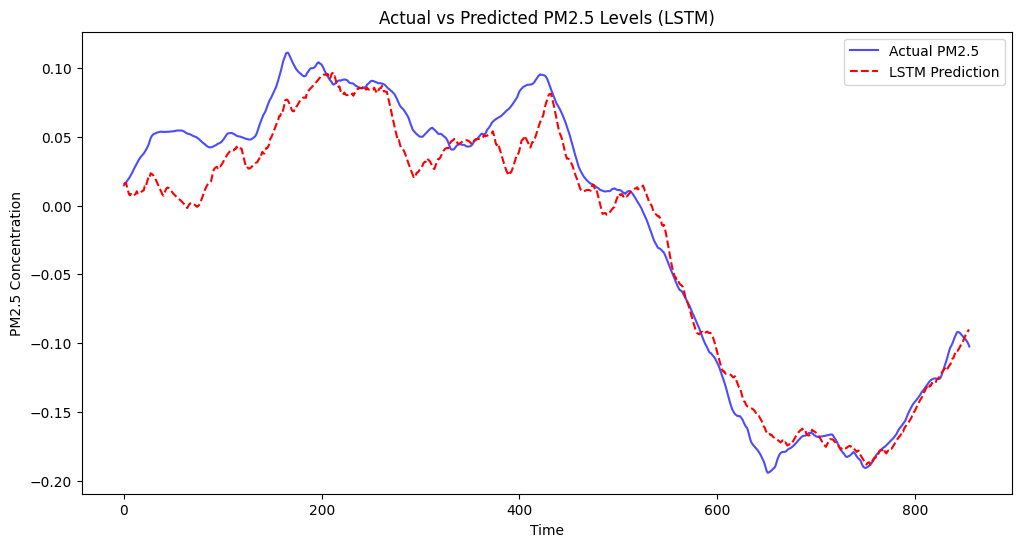

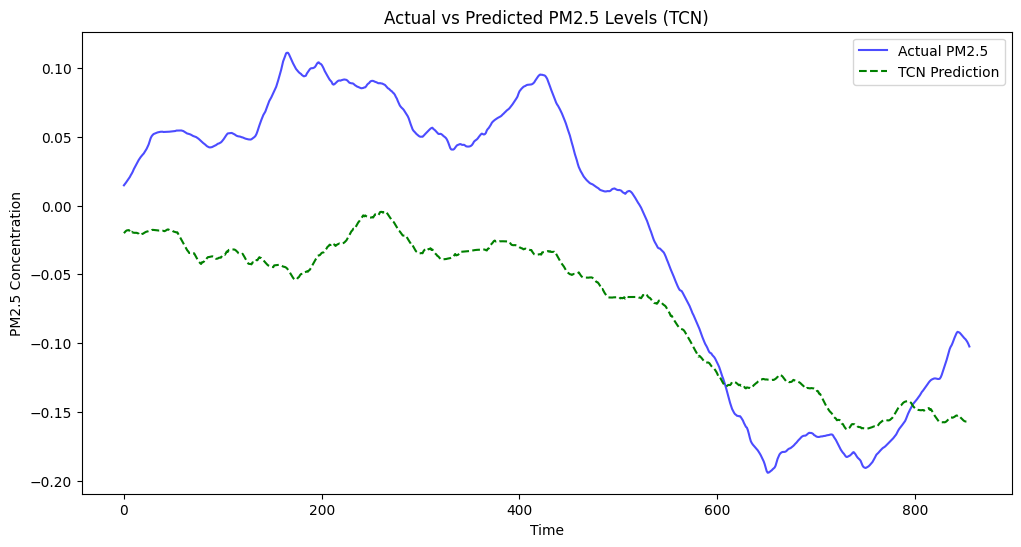

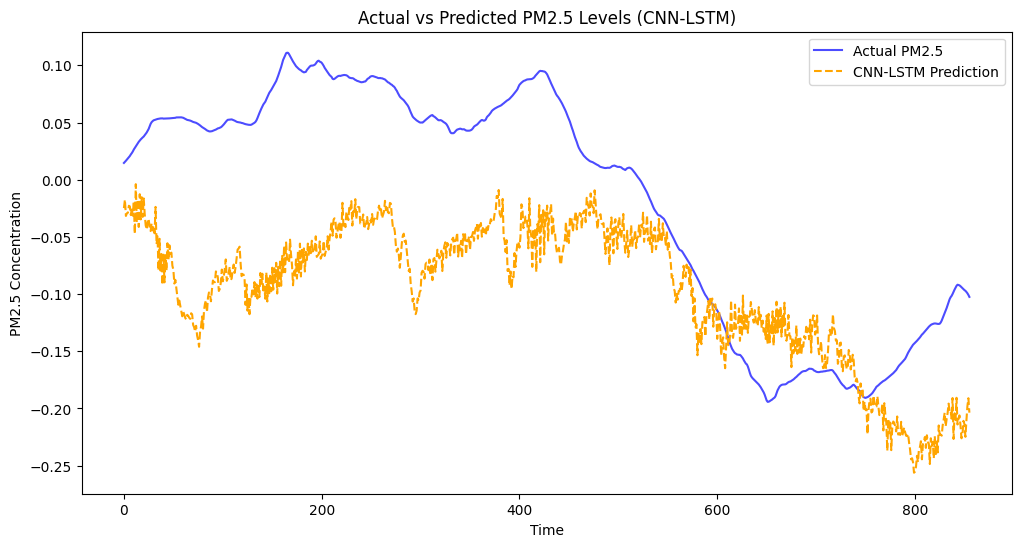

In [111]:
# Helper function for inverse transform
def inverse_transform(scaler, y_data, num_features):
    return scaler.inverse_transform(
        np.column_stack([np.zeros((len(y_data), num_features - 1)), y_data.flatten()])
    )[:, -1]

# Inverse transform actual values and predictions
y_test_actual = inverse_transform(scaler, y_test, num_features)
y_pred_actual_lstm = inverse_transform(scaler, y_pred_lstm, num_features)
y_pred_actual_tcn = inverse_transform(scaler, y_pred_tcn, num_features)
y_pred_actual_cnn_lstm = inverse_transform(scaler, y_pred_cnn_lstm, num_features)

# Plot for LSTM
plt.figure(figsize=(12, 6))
plt.plot(y_test_actual, label="Actual PM2.5", color='blue', alpha=0.7)
plt.plot(y_pred_actual_lstm, label="LSTM Prediction", color='red', linestyle="dashed")
plt.title("Actual vs Predicted PM2.5 Levels (LSTM)")
plt.xlabel("Time")
plt.ylabel("PM2.5 Concentration")
plt.legend()
plt.show()

# Plot for TCN
plt.figure(figsize=(12, 6))
plt.plot(y_test_actual, label="Actual PM2.5", color='blue', alpha=0.7)
plt.plot(y_pred_actual_tcn, label="TCN Prediction", color='green', linestyle="dashed")
plt.title("Actual vs Predicted PM2.5 Levels (TCN)")
plt.xlabel("Time")
plt.ylabel("PM2.5 Concentration")
plt.legend()
plt.show()

# Plot for Hybrid CNN-LSTM
plt.figure(figsize=(12, 6))
plt.plot(y_test_actual, label="Actual PM2.5", color='blue', alpha=0.7)
plt.plot(y_pred_actual_cnn_lstm, label="CNN-LSTM Prediction", color='orange', linestyle="dashed")
plt.title("Actual vs Predicted PM2.5 Levels (CNN-LSTM)")
plt.xlabel("Time")
plt.ylabel("PM2.5 Concentration")
plt.legend()
plt.show()

## Conclusion and Comparative Analysis

### Model Performance Comparison

| **Model**       | **Test Loss (MSE)** | **Test MAE** | **Test RMSE** |
|-----------------|---------------------|--------------|---------------|
| **LSTM**        | 0.0002              | 0.0109       | 0.0145        |
| **TCN**         | 0.0031              | 0.0491       | 0.0145        |
| **Hybrid (CNN-LSTM)** | 0.0054       | 0.0640       | 0.0145        |

### Model Discussion
1. **LSTM (Long Short-Term Memory)**  
   LSTM is a specialized form of recurrent neural networks (RNN) that excels in modeling time series data by capturing long-term dependencies. It handles sequential data effectively, preventing vanishing gradient problems through its memory cell structure.  
   **Benefit:** High accuracy and strong temporal modeling capabilities make LSTM ideal for forecasting tasks like air quality prediction.

2. **TCN (Temporal Convolutional Network)**  
   TCNs use causal convolutions to model time series, ensuring no information from future time steps is leaked into past predictions. Unlike LSTMs, TCNs are faster to train and parallelizable. However, they may require more data to reach optimal performance.  
   **Benefit:** Faster training time and stable gradients, making it suitable for large datasets or real-time applications.

3. **Hybrid CNN-LSTM**  
   This model combines the feature extraction capability of Convolutional Neural Networks (CNN) with the sequence modeling strength of LSTM. CNN layers capture short-term patterns in the data, while the LSTM layer models long-term dependencies.  
   **Benefit:** Offers the best of both worlds—efficient feature extraction and temporal pattern recognition—making it a robust solution for complex time series.

### Business Use Case
The prediction of **PM2.5** concentration is crucial for air quality monitoring and public health interventions. Among the models tested, **LSTM** showed superior performance, making it the most reliable choice for accurate forecasting. Accurate predictions allow government agencies to issue timely air quality warnings and help urban planners mitigate pollution hotspots.

### Future Steps
1. **Model Optimization:** Further optimize TCN and CNN-LSTM models by tuning hyperparameters to reduce error.
2. **Feature Engineering:** Include additional features like wind direction, humidity, and traffic patterns for improved accuracy.
3. **Real-Time Deployment:** Deploy the LSTM model on a cloud platform for real-time air quality prediction.
4. **Transfer Learning:** Explore pre-trained models to accelerate training and improve accuracy.